In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm

import pickle

from nltk.corpus import stopwords
STOP = stopwords.words('english')



import os

import networkx as nx

from utils import *
from plot_utils import *

In [2]:
tp = 'title'
BY_WEEK_RELS, BY_WEEK_RAW = pickle.load(open(f'data/{tp}_by_week.pkl', 'rb'))
MERGE_GRAMS = pickle.load(open('data/universal_merging_ngrams.pkl', 'rb'))
word_tfidf, word_idf = pickle.load(open('data/universal_tfidf.pkl', 'rb'))

In [3]:
def sus_score(posts, raw):
    color_score = {
        'green': 0.0,
        'yellow': 0.0,
        'orange': 1.0,
        'red': 1.0
    }
    res = []
    for _p in posts:
        res.append(color_score[raw[_p]['coding']])
    return res



act_mapping = {
    '5g': ['5g'],
    'coronavirus': ['SUPER:coronavirus|coronaviruses|postcoronavirus', 'coronavirus', 
                    'SUPER:coronavirus|coronavirus child|aronavirus', 'SUPER:coronavirus|coronaviruses|oronavirus', 
                    'SUPER:coronavirus|oronavirus', 'SUPER:coronavirus|coronaviruses|coronvirus', 
                    'SUPER:coronavirus|hantavirus|coronavirusfighting', 
                    'SUPER:coronavirus|coronavirus update liberals'],
    'spy': ['SUPER:diamond_princess_cruise|spy', 'spy'],
    'lab': ['SUPER:zoo|laboratory', 'SUPER:lab|laboratory', 'SUPER:room|laboratory', 'SUPER:lab|clinic',  
            'biolab', 'SUPER:lab|clinic|laboratory', 'lab'],
    'bioweapon': ['bioweapon'],
    'virus': ['SUPER:virus|deadly_virus',  'SUPER:virus_outbreak|deadly_virus',
          'SUPER:outbreak|virus_outbreak', 'SUPER:outbreak|virus_outbreak|epidemic',  'SUPER:deadly_virus|deadly',
          'SUPER:virus_outbreak|virus|infection'],
    'wuhan_virus': ['SUPER:wuhan_virus|dr._anthony_fauci|matt_hancock', 'SUPER:wuhan_virus|brexit|angelina_jolie', 'SUPER:wuhan_virus|shamima_begum'
         'SUPER:wuhan_virus|wuhan', 'SUPER:wuhan_virus|deadly_virus'],
    'china_virus': ['chinavirus', 'SUPER:chinese_virus|chinese|chinese_communist_party', 
                'SUPER:chinese_virus|chinese', 'SUPER:virus|chinese_virus|deadly_virus',  
                'SUPER:virus_outbreak|chinese_virus', 'SUPER:virus_outbreak|virus|chinese_virus',
                'SUPER:virus|chinese_virus']
}

centres = ['coronavirus', 'virus']
rumors = ['5g', 'spy', 'lab', 'bioweapon']


In [4]:
#input weekly

df_ind = ['week', 
        '#green_art', '#yellow_art', '#orange_art', '#red_art',
         '#nodes',
         'density',
         'clust_coef',
         '#green_node', '#yellow_node', '#orange_node', '#red_node'
        ]


weekly_rumors = {key: {} for key in rumors}
target_effort = 'sus'

weekly_stats = pd.DataFrame(columns=df_ind)


all_nodes = set([])


for week_num in range(4, 18):
    print(f'=======================\nprocessing week {week_num}\n=========================')
    
    name = f'title_week_{week_num}'

    DF_RELS = BY_WEEK_RELS[week_num]
    RAW_META = BY_WEEK_RAW[week_num]
    #find triplets while merging n-grams, and find arc words
    if os.path.exists(f'data/cache/cached_ACTANTS_{name}.pkl'):
        actants, triplets, verbs = pickle.load(open(f'data/cache/cached_actants_{name}.pkl', 'rb'))
    else:
        actants, triplets, verbs = extract_args(DF_RELS, merge_grams=MERGE_GRAMS)
        pickle.dump((actants, triplets, verbs), open(f'data/cache/cached_actants_{name}.pkl', 'wb'))
        
    #query actants embedding

    if os.path.exists(f'data/cache/cached_actant_emb_{name}.pkl'):
        actant_emb = pickle.load(open(f'data/cache/cached_actant_emb_{name}.pkl', 'rb'))
    else:
        from bert_serving.client import BertClient
        bc = BertClient(ip='picso-gpu.exp.sis.pitt.edu', port=5555)

        actant_emb = {}
        for _actant in tqdm(actants):

            if _actant == '':
                actant_emb[_actant] = np.zeros(768)
                continue

            tokens = _actant.split('_')

            emb = np.average(bc.encode(tokens), axis=0)

            actant_emb[_actant] = emb


        pickle.dump(actant_emb, open(f'data/cache/cached_actant_emb_{name}.pkl', 'wb'))

    actant_list = list(actant_emb.keys())

    node_emb_array = []
    for actant in actant_list:
        node_emb_array.append(actant_emb[actant])
    node_emb_array = np.array(node_emb_array)
    node_emb_array.shape

    answer = metrics.pairwise.cosine_similarity(node_emb_array)

    # distrib = []
    # for i in tqdm(range(len(answer))):
    #     for j in range(i+1, len(answer)):
    #         distrib.append(answer[i][j])

    # plt.hist(distrib, bins=400)
    # plt.show()
    
    
    
    #merge to super-nodes


    threshold = 0.95

    actant2superid = {}
    super_nodes = {}


    
    for i in tqdm(range(len(answer))):
        node1 = actant_list[i]
        for j in range(i + 1, len(answer)):
            node2 = actant_list[j]
            if answer[i][j] >= 0.95:
                if node1 in actant2superid:
                    super_id = actant2superid[node1]

                    #add j
                    flag = True
                    for exist in super_nodes[super_id]:
                        if answer[j][actant_list.index(exist)] < 0.95:
                            flag = False
                            break
                    if flag:
                        super_nodes[super_id].add(node2)
                        actant2superid[node2] = super_id

                elif node1 in actant2superid:
                    super_id = actant2superid[node2]

                    #add j
                    flag = True
                    for exist in super_nodes[super_id]:
                        if answer[i][actant_list.index(exist)] < 0.95:
                            flag = False
                            break
                    if flag:
                        super_nodes[super_id].add(node1)
                        actant2superid[node1] = super_id

                else:
                    super_id = max_id(super_nodes)

                    #add both

                    super_nodes[super_id] = set([])

                    super_nodes[super_id].add(node1)
                    super_nodes[super_id].add(node2)


                    actant2superid[node1] = super_id
                    actant2superid[node2] = super_id

    superid2names = {}
    for i in super_nodes:
        _name = get_super_node_label(super_nodes[i], word_tfidf)
        superid2names[i] = _name
        
    #generate supernode meta

    super_meta = {}

    for _superid in super_nodes:

        _name = superid2names[_superid]
        _all_acts = super_nodes[_superid]
        _all_posts = []

        for _act in _all_acts:    
            _act_meta = actants[_act]
            _posts = [item['post'] for item in _act_meta]
            _all_posts += _posts

        _all_posts = set(_all_posts)

        _act_idf = len(RAW_META) / len(_all_posts)
        _act_pop = np.mean([RAW_META[idx]['pop'] for idx in _all_posts])
        _act_rt = np.mean([RAW_META[idx]['rt'] for idx in _all_posts])
        _act_fav = np.mean([RAW_META[idx]['fav'] for idx in _all_posts])

        _colors = [RAW_META[idx]['coding'] for idx in _all_posts]
        _color_mat = np.array([_colors.count(c)/len(_colors) for c in ['green', 'yellow', 'orange', 'red']])


        super_meta[_name] = {
            'idf': _act_idf,
            'pop': _act_pop,
            'rt': _act_rt,
            'fav': _act_fav,
            'color': _color_mat,
            'freq': len(_all_posts)
        }

    #generate node meta and edge meta



    # name, pop, rt, 
    nodes_in_graph = {}
    # key, from, to, idfs, verbs
    und_edges_in_graph = {}
    dir_edges_in_graph = {}

    for trip in tqdm(triplets):
        _from = trip.split('->')[0]
        _verb = trip.split('->')[1]
        _to = trip.split('->')[2]

        
        _to_posts = set([item['post'] for item in actants[_to]])

        if _from in actant2superid:
            _from = superid2names[actant2superid[_from]]
            nodes_in_graph[_from] = super_meta[_from]
        else:
            _from_posts = set([item['post'] for item in actants[_from]])
            _from_idf = len(RAW_META) / len(_from_posts)
            _from_pop = np.mean([RAW_META[idx]['pop'] for idx in _from_posts])
            _from_rt = np.mean([RAW_META[idx]['rt'] for idx in _from_posts])
            _from_fav = np.mean([RAW_META[idx]['fav'] for idx in _from_posts])
            
            _from_colors = [RAW_META[idx]['coding'] for idx in _from_posts]
            _from_color_mat = np.array([_from_colors.count(c)/len(_from_colors) for c in ['green', 'yellow', 'orange', 'red']])

            nodes_in_graph[_from] = {
                'idf': _from_idf,
                'pop': _from_pop,
                'rt': _from_rt,
                'fav': _from_fav,
                'color': _from_color_mat,
                'freq': len(_from_posts)
            }

        if _to in actant2superid:
            _to = superid2names[actant2superid[_to]]
            nodes_in_graph[_to] = super_meta[_to]
        else:
            _to_posts = set([item['post'] for item in actants[_to]])
            _to_idf = len(RAW_META) / len(_to_posts)
            _to_pop = np.mean([RAW_META[idx]['pop'] for idx in _to_posts])
            _to_rt = np.mean([RAW_META[idx]['rt'] for idx in _to_posts])
            _to_fav = np.mean([RAW_META[idx]['fav'] for idx in _to_posts])

            _to_colors = [RAW_META[idx]['coding'] for idx in _to_posts]
            _to_color_mat = np.array([_to_colors.count(c)/len(_to_colors) for c in ['green', 'yellow', 'orange', 'red']])

            nodes_in_graph[_to] = {
                'idf': _to_idf,
                'pop': _to_pop,
                'rt': _to_rt,
                'fav': _to_fav,
                'color': _to_color_mat,
                'freq': len(_to_posts)
            }



        if _from < _to:
            _und_id =  f'{_from}<->{_to}'
        else:
            _und_id =  f'{_to}<->{_from}'

        _dir_id = f'{_from}->{_to}'

        if _und_id not in und_edges_in_graph:
            und_edges_in_graph[_und_id] = []

        if _dir_id not in dir_edges_in_graph:
            dir_edges_in_graph[_dir_id] = []


        _verb_idf = np.log(len(RAW_META) / len(verbs[_verb]))
        _sus = sus_score(triplets[trip], RAW_META)

        _edge_color = color_mat(triplets[trip], RAW_META)


        und_edges_in_graph[_und_id].append({'verb': _verb, 'idf': _verb_idf, 'suspicious': _sus, 'color': _edge_color})
        dir_edges_in_graph[_dir_id].append({'verb': _verb, 'idf': _verb_idf, 'suspicious': _sus, 'color': _edge_color})

        
        
    print('building und graph')
    G = build_graph_perc_filter(nodes_in_graph, und_edges_in_graph, filter_it=-1, directed=False)

    print('building dir graph')
    GD = build_graph_perc_filter(nodes_in_graph, dir_edges_in_graph, filter_it=-1, directed=True)

    
    # #output nodes. graphs
    out = (G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph)
    pickle.dump(out, open(f'output/graph_{name}.pkl', 'wb'))
    
    
    art_colors = [RAW_META[aid]['coding'] for aid in RAW_META]
    node_colors = [take_node_color(nodes_in_graph[node]) for node in G.nodes()]
    row = [week_num]
    
    density = nx.density(G)
    clust = nx.average_clustering(G)
    
    for color in ['green', 'yellow', 'orange', 'red']:
        row.append(art_colors.count(color))
        
    row.append(len(G.nodes()))
    row.append(density)
    row.append(clust)
    for color in ['green', 'yellow', 'orange', 'red']:
        row.append(node_colors.count(color))
        
    weekly_stats = weekly_stats.append(pd.Series(row, index=df_ind), ignore_index=True)
    
    all_nodes.update(G.nodes())
    
    
    
    centre_lst = []
    for centre in centres:
        centre_lst += any_in(act_mapping[centre], G)
    centre_lst = set(centre_lst)
    
    for rumor in rumors:
        _nd_lst = any_in(act_mapping[rumor], G)
        rumor_nodes = []
        for _nd in _nd_lst:
            for _cd in centre_lst:
                rumor_nodes += show_shortest_path(G, _nd, _cd, effort='sus') #most un-sus
                rumor_nodes += show_shortest_path(G, _nd, _cd, effort='rev_sus') #most un-sus
                rumor_nodes += show_shortest_path(G, _nd, _cd, weighted=False) #shortest
                rumor_nodes += show_shortest_path(G, _nd, _cd, effort='reverse_w') #most popular
                rumor_nodes += show_shortest_path(G, _nd, _cd, effort='weight') #least popular
        rumor_nodes = set(rumor_nodes)
        if len(rumor_nodes) > 0:
            sub_G = G.subgraph(rumor_nodes)
        else:
            sub_G = None
        
        weekly_rumors[rumor][week_num] = sub_G
    

 50%|████▉     | 788/1591 [00:00<00:00, 7868.30it/s]

processing week 4


 22%|██▏       | 772/3477 [00:00<00:00, 7709.68it/s]

building und graph
before removal of low degree nodes: #nodes=460
after removal of low degree nodes: #nodes=460
building dir graph
before removal of low degree nodes: #nodes=460
after removal of low degree nodes: #nodes=460
processing week 5


100%|██████████| 1572/1572 [00:00<00:00, 10038.57it/s]


building und graph
before removal of low degree nodes: #nodes=911
after removal of low degree nodes: #nodes=911
building dir graph
before removal of low degree nodes: #nodes=911
after removal of low degree nodes: #nodes=911


 26%|██▌       | 728/2852 [00:00<00:00, 7279.63it/s]

processing week 6


100%|██████████| 1289/1289 [00:00<00:00, 8553.13it/s]


building und graph
before removal of low degree nodes: #nodes=871
after removal of low degree nodes: #nodes=871
building dir graph
before removal of low degree nodes: #nodes=871
after removal of low degree nodes: #nodes=871


 23%|██▎       | 771/3391 [00:00<00:00, 7692.14it/s]

processing week 7


100%|██████████| 1528/1528 [00:00<00:00, 13076.31it/s]


building und graph
before removal of low degree nodes: #nodes=970
after removal of low degree nodes: #nodes=970
building dir graph
before removal of low degree nodes: #nodes=970
after removal of low degree nodes: #nodes=970


 33%|███▎      | 736/2254 [00:00<00:00, 7356.17it/s]

processing week 8


100%|██████████| 1053/1053 [00:00<00:00, 9488.27it/s]


building und graph
before removal of low degree nodes: #nodes=779
after removal of low degree nodes: #nodes=779
building dir graph
before removal of low degree nodes: #nodes=779
after removal of low degree nodes: #nodes=779


 11%|█▏        | 660/5775 [00:00<00:00, 6592.15it/s]

processing week 9


100%|██████████| 2625/2625 [00:00<00:00, 12102.28it/s]


building und graph
before removal of low degree nodes: #nodes=1331
after removal of low degree nodes: #nodes=1331
building dir graph
before removal of low degree nodes: #nodes=1331
after removal of low degree nodes: #nodes=1331


  9%|▊         | 659/7588 [00:00<00:01, 6580.40it/s]

processing week 10


100%|██████████| 3314/3314 [00:00<00:00, 6139.82it/s]


building und graph
before removal of low degree nodes: #nodes=1613
after removal of low degree nodes: #nodes=1613
building dir graph
before removal of low degree nodes: #nodes=1613
after removal of low degree nodes: #nodes=1613


  9%|▉         | 721/7662 [00:00<00:00, 7206.28it/s]

processing week 11


100%|██████████| 3401/3401 [00:00<00:00, 13106.50it/s]


building und graph
before removal of low degree nodes: #nodes=1656
after removal of low degree nodes: #nodes=1656
building dir graph
before removal of low degree nodes: #nodes=1656
after removal of low degree nodes: #nodes=1656


  7%|▋         | 669/9333 [00:00<00:01, 6679.46it/s]

processing week 12


100%|██████████| 4142/4142 [00:00<00:00, 12034.32it/s]


building und graph
before removal of low degree nodes: #nodes=2001
after removal of low degree nodes: #nodes=2001
building dir graph
before removal of low degree nodes: #nodes=2001
after removal of low degree nodes: #nodes=2001


  5%|▌         | 609/11153 [00:00<00:01, 6089.56it/s]

processing week 13


100%|██████████| 4833/4833 [00:00<00:00, 13230.09it/s]


building und graph
before removal of low degree nodes: #nodes=2185
after removal of low degree nodes: #nodes=2185
building dir graph
before removal of low degree nodes: #nodes=2185
after removal of low degree nodes: #nodes=2185


  6%|▌         | 648/11009 [00:00<00:01, 6476.90it/s]

processing week 14


100%|██████████| 4591/4591 [00:00<00:00, 12323.26it/s]


building und graph
before removal of low degree nodes: #nodes=2212
after removal of low degree nodes: #nodes=2212
building dir graph
before removal of low degree nodes: #nodes=2212
after removal of low degree nodes: #nodes=2212


  6%|▌         | 615/10040 [00:00<00:01, 6142.11it/s]

processing week 15


100%|██████████| 4265/4265 [00:00<00:00, 12990.38it/s]


building und graph
before removal of low degree nodes: #nodes=2082
after removal of low degree nodes: #nodes=2082
building dir graph
before removal of low degree nodes: #nodes=2082
after removal of low degree nodes: #nodes=2082


  7%|▋         | 671/9828 [00:00<00:01, 6701.94it/s]

processing week 16


100%|██████████| 4147/4147 [00:00<00:00, 12364.99it/s]


building und graph
before removal of low degree nodes: #nodes=2010
after removal of low degree nodes: #nodes=2010
building dir graph
before removal of low degree nodes: #nodes=2010
after removal of low degree nodes: #nodes=2010


  9%|▊         | 591/6783 [00:00<00:01, 5891.98it/s]

processing week 17


100%|██████████| 2932/2932 [00:00<00:00, 13092.92it/s]


building und graph
before removal of low degree nodes: #nodes=1667
after removal of low degree nodes: #nodes=1667
building dir graph
before removal of low degree nodes: #nodes=1667
after removal of low degree nodes: #nodes=1667


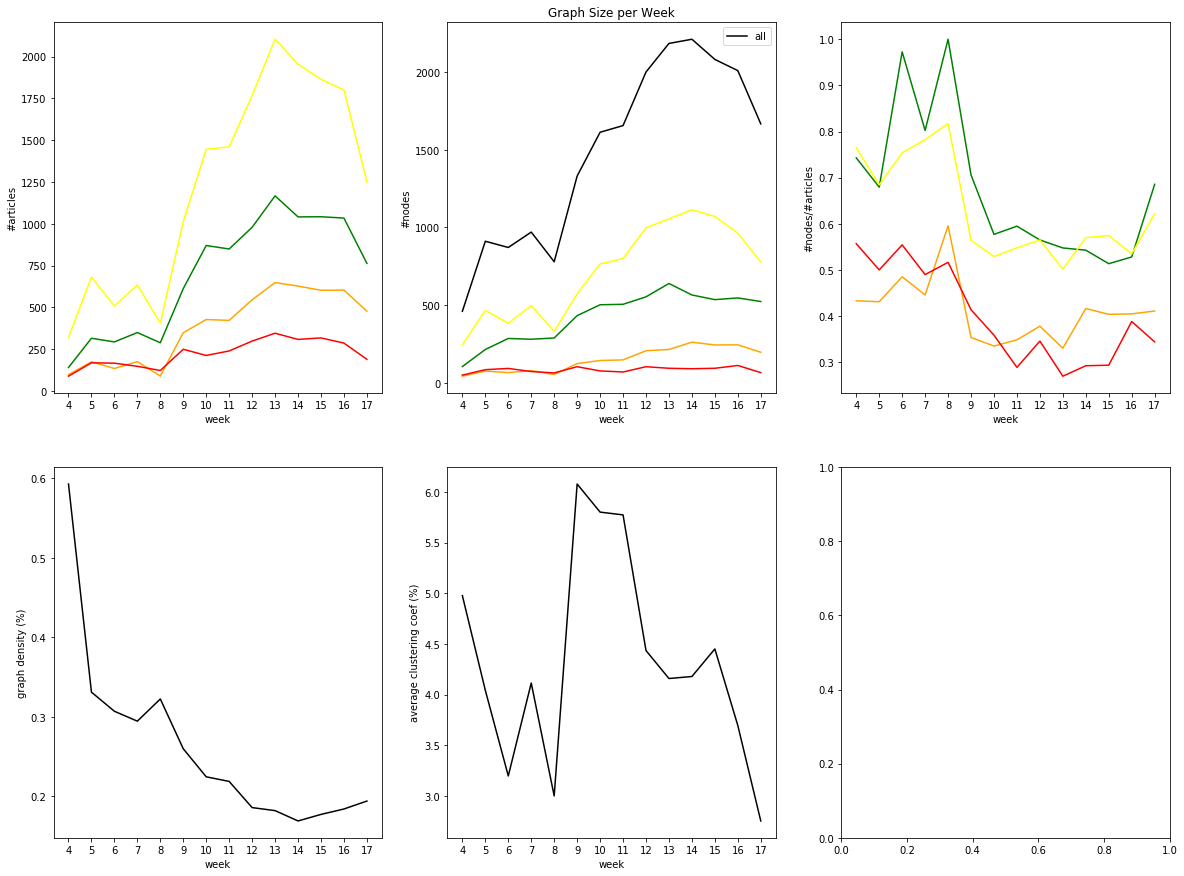

In [5]:
import matplotlib
import matplotlib.pyplot as plt

#article vs. graph size (by color)

fig, ax = plt.subplots(2, 3, figsize=(20, 15))

for color in ['green', 'yellow', 'orange', 'red']:
    ax[0][0].plot(weekly_stats[f'#{color}_art'], color=color)
    
ax[0][0].set_xticks(range(len(weekly_stats)))
ax[0][0].set_xticklabels([f'{item:.0f}' for item in weekly_stats['week']])
# ax[0][0].set_title(f'#articles per week')
ax[0][0].set_ylabel('#articles')
ax[0][0].set_xlabel('week')

for color in ['green', 'yellow', 'orange', 'red']:
    ax[0][1].plot(weekly_stats[f'#{color}_node'], color=color)
    
ax[0][1].plot(weekly_stats['#nodes'], color='black', label='all')

ax[0][1].legend()
    
ax[0][1].set_xticks(range(len(weekly_stats)))
ax[0][1].set_xticklabels([f'{item:.0f}' for item in weekly_stats['week']])
ax[0][1].set_title(f'Graph Size per Week')
ax[0][1].set_ylabel('#nodes')
ax[0][1].set_xlabel('week')

for color in ['green', 'yellow', 'orange', 'red']:
    ax[0][2].plot(weekly_stats[f'#{color}_node'] / weekly_stats[f'#{color}_art'], color=color)
    
ax[0][2].set_xticks(range(len(weekly_stats)))
ax[0][2].set_xticklabels([f'{item:.0f}' for item in weekly_stats['week']])
# ax[0][0].set_title(f'#articles per week')
ax[0][2].set_ylabel('#nodes/#articles')
ax[0][2].set_xlabel('week')


ax[1][0].plot(weekly_stats['density'] * 100, color='black')
ax[1][0].set_xticks(range(len(weekly_stats)))
ax[1][0].set_xticklabels([f'{item:.0f}' for item in weekly_stats['week']])
ax[1][0].set_ylabel('graph density (%)')
ax[1][0].set_xlabel('week')


ax[1][1].plot(weekly_stats['clust_coef'] * 100, color='black')
ax[1][1].set_xticks(range(len(weekly_stats)))
ax[1][1].set_xticklabels([f'{item:.0f}' for item in weekly_stats['week']])
ax[1][1].set_ylabel('average clustering coef (%)')
ax[1][1].set_xlabel('week')

plt.show()

In [6]:
fields = ['week', 'size_sub_graph', 'shortest_length', 'least_suspicious', 'most_suspicious', 'least_popular', 'most_popular']
rumor_df = {}



for rumor in rumors:
    _rdf = pd.DataFrame(columns=fields)
    for week in range(4, 18):
        _graph = weekly_rumors[rumor][week]
        
        if _graph is None:
            out = [f'{week:.0f}', 0, -1,
              -1,
              -1,
              -1,
              -1]
            _rdf = _rdf.append(pd.Series(out, index=fields), ignore_index=True)
            continue
            
        _centre_lst = []
        for centre in centres:
            _centre_lst += any_in(act_mapping[centre], _graph)
        _centre_lst = set(_centre_lst)
        
        
        _nd_lst = any_in(act_mapping[rumor], _graph)
        
        
        out = [f'{week:.0f}', len(_graph), get_average_effort(_graph, _centre_lst, _nd_lst, weighted=False),
              get_average_effort(_graph, _centre_lst, _nd_lst, effort='sus', ret='sus'),
              get_average_effort(_graph, _centre_lst, _nd_lst, effort='rev_sus', ret='sus'),
              get_average_effort(_graph, _centre_lst, _nd_lst, effort='weight', ret='weight'),
              get_average_effort(_graph, _centre_lst, _nd_lst, effort='reverse_w', ret='weight')]
        
        _rdf = _rdf.append(pd.Series(out, index=fields), ignore_index=True)
        
    rumor_df[rumor] = _rdf

In [20]:
rumor_df['bioweapon']

,week,size_sub_graph,shortest_length,least_suspicious,most_suspicious,least_popular,most_popular
0,4,0,-1,-1,-1,-1,-1
1,5,13,2.33333,0.361111,1,7.46411,10.2082
2,6,0,-1,-1,-1,-1,-1
3,7,11,2.5,0.416667,0.922619,6.43549,18.7506
4,8,6,1.5,0.666667,1,3.62761,3.62761
5,9,13,2,0.305556,1,4.34964,14.9097
6,10,15,2,0.291667,0.958333,3.43628,13.2312
7,11,0,-1,-1,-1,-1,-1
8,12,0,-1,-1,-1,-1,-1
9,13,0,-1,-1,-1,-1,-1


In [21]:
rm = 'bioweapon'
wk = 5
fig = plot_rumor(rm, wk, weekly_rumors[rm][wk], act_mapping, centres)
fig

/home/muheng/.local/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:441: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


/home/muheng/.local/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [22]:
rm = 'bioweapon'
wk = 7
fig = plot_rumor(rm, wk, weekly_rumors[rm][wk], act_mapping, centres)
fig

In [23]:
rm = 'bioweapon'
wk = 8
fig = plot_rumor(rm, wk, weekly_rumors[rm][wk], act_mapping, centres)
fig

In [24]:
rm = 'bioweapon'
wk = 9
fig = plot_rumor(rm, wk, weekly_rumors[rm][wk], act_mapping, centres)
fig

In [25]:
rm = 'bioweapon'
wk = 10
fig = plot_rumor(rm, wk, weekly_rumors[rm][wk], act_mapping, centres)
fig

In [26]:
rm = 'bioweapon'
wk = 16
fig = plot_rumor(rm, wk, weekly_rumors[rm][wk], act_mapping, centres)
fig